In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [3]:
!pip install transformers
from transformers import AutoTokenizer, TFAutoModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 163 kB 68.2 MB/s 
     |████████████████████████████████| 7.6 MB 48.5 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load dataset
# dataset from https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset
data = pd.read_csv('/content/drive/MyDrive/Data Mining/dataset.csv')
data

,Tweet,label
0,di saat cowok usaha lacak perhati gue kamu lan...,1
1,telat beri tau kamu edan sarap gue gaul cigax ...,0
2,41 kadang pikir percaya tuhan jatuh kali kadan...,0
3,ku tau mata sipit lihat,0
4,kaum cebong kafir sudah lihat dongok dungu haha,2
...,...,...
13164,bicara ndasmu congor kamu yang sekata kata anjing,1
13165,kasur kunyuk,0
13166,hati hati bisu lagi bosan duh,0
13167,bom real mudah deteksi bom kubur dahsyat ledak...,0


In [6]:
for i in range(len(data)):
    if(type(data['Tweet'][i]) == float):
        data.drop(i,axis=0,inplace=True)

In [7]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(data['Tweet'],data['label'],stratify=data['label'],test_size=0.20)

(10495, 2)


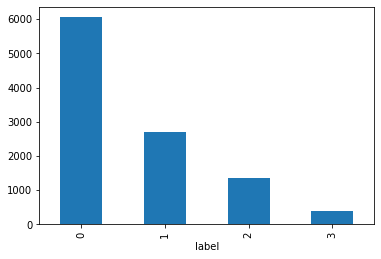

In [8]:
df_train = pd.DataFrame(list(zip(X_train, y_train)), columns=['Tweet', 'label'])
df_train.groupby(['label']).size().plot(kind='bar')
print(df_train.shape)

(2624, 2)


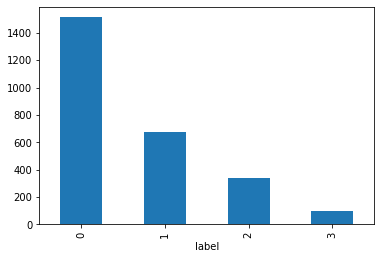

In [9]:
df_test = pd.DataFrame(list(zip(X_test, y_test)), columns=['Tweet', 'label'])
df_test.groupby(['label']).size().plot(kind='bar')
print(df_test.shape)

In [10]:
y_train = tf.keras.utils.to_categorical(df_train['label'])
y_test = tf.keras.utils.to_categorical(df_test['label'])

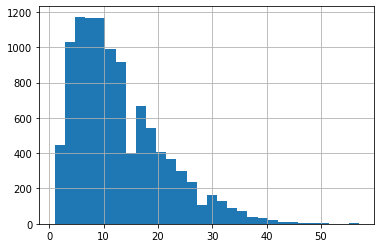

In [11]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df_train['Tweet']]

pd.Series(seq_len).hist(bins = 30)

In [12]:
# load pre-trained model BERT
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
bert = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# tokenizing
max_len = 40 # from histogram length words
x_train = tokenizer(text=df_train['Tweet'].tolist(),
                    add_special_tokens=True,
                    max_length=max_len,
                    truncation=True,
                    padding='max_length',
                    return_tensors='tf',
                    return_token_type_ids=False,
                    return_attention_mask=True,
                    verbose=True)
x_test = tokenizer(text=df_test['Tweet'].tolist(),
                   add_special_tokens=True,
                   max_length=max_len,
                   truncation=True,
                   padding='max_length',
                   return_tensors='tf',
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [17]:
# build model fine tuning bert
input_ids = tf.keras.layers.Input(
    shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(
    shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids, attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = tf.keras.layers.Dense(64, activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = tf.keras.layers.Dense(32, activation='relu')(out)

y = tf.keras.layers.Dense(4, activation='softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = tf.keras.optimizers.Adam(
    # this learning rate is for bert model , taken from huggingface website
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  110558208   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                          

In [18]:
# model training
history = model.fit( x={'input_ids': x_train['input_ids'],'attention_mask': x_train['attention_mask']},
                    y=y_train,
                    validation_data=({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, y_test),
                    epochs=3,
                    batch_size=32
)

Epoch 1/3


328/328 [==============================] - 128s 324ms/step - loss: 0.9005 - balanced_accuracy: 0.6407 - val_loss: 0.7451 - val_balanced_accuracy: 0.6997
Epoch 2/3
328/328 [==============================] - 105s 319ms/step - loss: 0.6757 - balanced_accuracy: 0.7412 - val_loss: 0.6624 - val_balanced_accuracy: 0.7351
Epoch 3/3
328/328 [==============================] - 101s 308ms/step - loss: 0.5860 - balanced_accuracy: 0.7834 - val_loss: 0.6415 - val_balanced_accuracy: 0.7378


In [19]:
# prediction
predicted_raw = model.predict(
    {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

y_predicted = np.argmax(predicted_raw, axis=1)
y_true = df_test['label']

print(classification_report(y_true, y_predicted))

82/82 [==============================] - 8s 80ms/step
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1513
           1       0.61      0.66      0.63       675
           2       0.47      0.56      0.51       341
           3       0.68      0.71      0.69        95

    accuracy                           0.74      2624
   macro avg       0.66      0.69      0.67      2624
weighted avg       0.76      0.74      0.74      2624

